# Predictive Maintenance for Industrial IoT
## Step 1: Data Collection & Preprocessing and Step 2: Exploratory Data Analysis (EDA)

This notebook covers:
1. Loading the APS Failure dataset
2. Data exploration and visualization
3. Data preprocessing (handling missing values, scaling)
4. Feature importance analysis


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import warnings

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

# Display all columns in pandas dataframes
pd.set_option('display.max_columns', None)


### Step 1.1: Loading the Dataset


In [2]:
# Define paths to dataset files
data_dir = '../aps_failure_at_scania_trucks'
train_file = os.path.join(data_dir, 'aps_failure_training_set.csv')
test_file = os.path.join(data_dir, 'aps_failure_test_set.csv')

# Load the training and test datasets
print(f"Loading training data from {train_file}")
train_data = pd.read_csv(train_file)

print(f"Loading test data from {test_file}")
test_data = pd.read_csv(test_file)

# Display basic information about the datasets
print("\nTraining dataset info:")
print(f"Shape: {train_data.shape}")
print(f"Class distribution: \n{train_data['class'].value_counts()}")

print("\nTest dataset info:")
print(f"Shape: {test_data.shape}")
print(f"Class distribution: \n{test_data['class'].value_counts()}")


Loading training data from ../aps_failure_at_scania_trucks\aps_failure_training_set.csv
Loading test data from ../aps_failure_at_scania_trucks\aps_failure_test_set.csv

Training dataset info:
Shape: (60000, 171)
Class distribution: 
class
neg    59000
pos     1000
Name: count, dtype: int64

Test dataset info:
Shape: (16000, 171)
Class distribution: 
class
neg    15625
pos      375
Name: count, dtype: int64


### Step 1.2: Data Exploration


In [3]:
# Extract features and labels
# Convert class labels to binary (0 for neg, 1 for pos)
y_train = train_data['class'].map({'neg': 0, 'pos': 1})
y_test = test_data['class'].map({'neg': 0, 'pos': 1})

# Extract features (all columns except 'class')
X_train = train_data.drop('class', axis=1)
X_test = test_data.drop('class', axis=1)

# Display the first few rows of the training data
print("First 5 rows of training data:")
display(X_train.head())

# Check data types
print("\nData types:")
display(X_train.dtypes.value_counts())

# Check for missing values
print("\nMissing values in training data:")
missing_train = X_train.isnull().sum()
print(f"Total columns with missing values: {sum(missing_train > 0)}")
print(f"Columns with most missing values:")
display(missing_train[missing_train > 0].sort_values(ascending=False).head(10))

# Check for 'na' string values which are not caught by isnull()
print("\nChecking for 'na' string values:")
na_counts = {}
for col in X_train.columns:
    na_count = (X_train[col] == 'na').sum()
    if na_count > 0:
        na_counts[col] = na_count

print(f"Total columns with 'na' string values: {len(na_counts)}")
if na_counts:
    print("Top 10 columns with 'na' string values:")
    display(pd.Series(na_counts).sort_values(ascending=False).head(10))

# Basic statistics of the training data
print("\nBasic statistics of numerical columns (after converting 'na' to NaN):")
X_train_numeric = X_train.replace('na', np.nan).apply(pd.to_numeric, errors='coerce')
display(X_train_numeric.describe())


First 5 rows of training data:


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,1209600,302,2,6,0,2135.04,0,


Data types:


object    169
int64       1
Name: count, dtype: int64


Missing values in training data:
Total columns with missing values: 0
Columns with most missing values:


Series([], dtype: int64)


Checking for 'na' string values:
Total columns with 'na' string values: 169
Top 10 columns with 'na' string values:


br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
cr_000    46329
bn_000    44009
bm_000    39549
bl_000    27277
bk_000    23034
dtype: int64


Basic statistics of numerical columns (after converting 'na' to NaN):


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,59329.000000,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.931200e+04,5.935500e+04,57275.000000,57273.000000,57497.000000,57500.000000,5.935800e+04,5.935800e+04,5.941100e+04,5.941100e+04,3.696600e+04,3.272300e+04,2.045100e+04,1.599100e+04,1.366700e+04,1.226000e+04,1.127800e+04,1.073600e+04,5.927400e+04,5.983300e+04,5.930900e+04,5.930900e+04,5.674300e+04,5.952700e+04,5.727700e+04,55644.000000,5.927400e+04,5.674500e+04,59324.0,5.749800e+04,4.513900e+04,45139.000000,45139.000000,5.966200e+04,5.966200e+04,5.966200e+04,50447.000000,50123.000000,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,5.931300e+04,4.513900e+04,57276.000000,5.930900e+04,13671.000000,59331.000000,59331.000000,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,5.933100e+04,46192.000000,46192.000000,4.619200e+04,4.619200e+04,46192.000000,4.619200e+04,46192.000000,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,1.546032e+06,1.051123e+06,1.162622e+03,7.849608e+03,4.420992e+03,8.066082e+03,8.724082e+04,1.476897e+06,2.1

### Step 1.3: Data Visualization


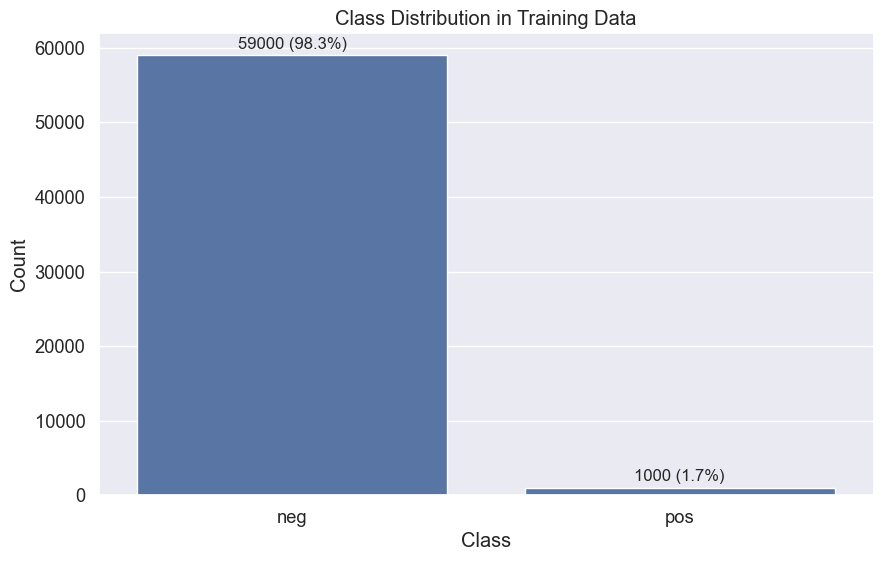

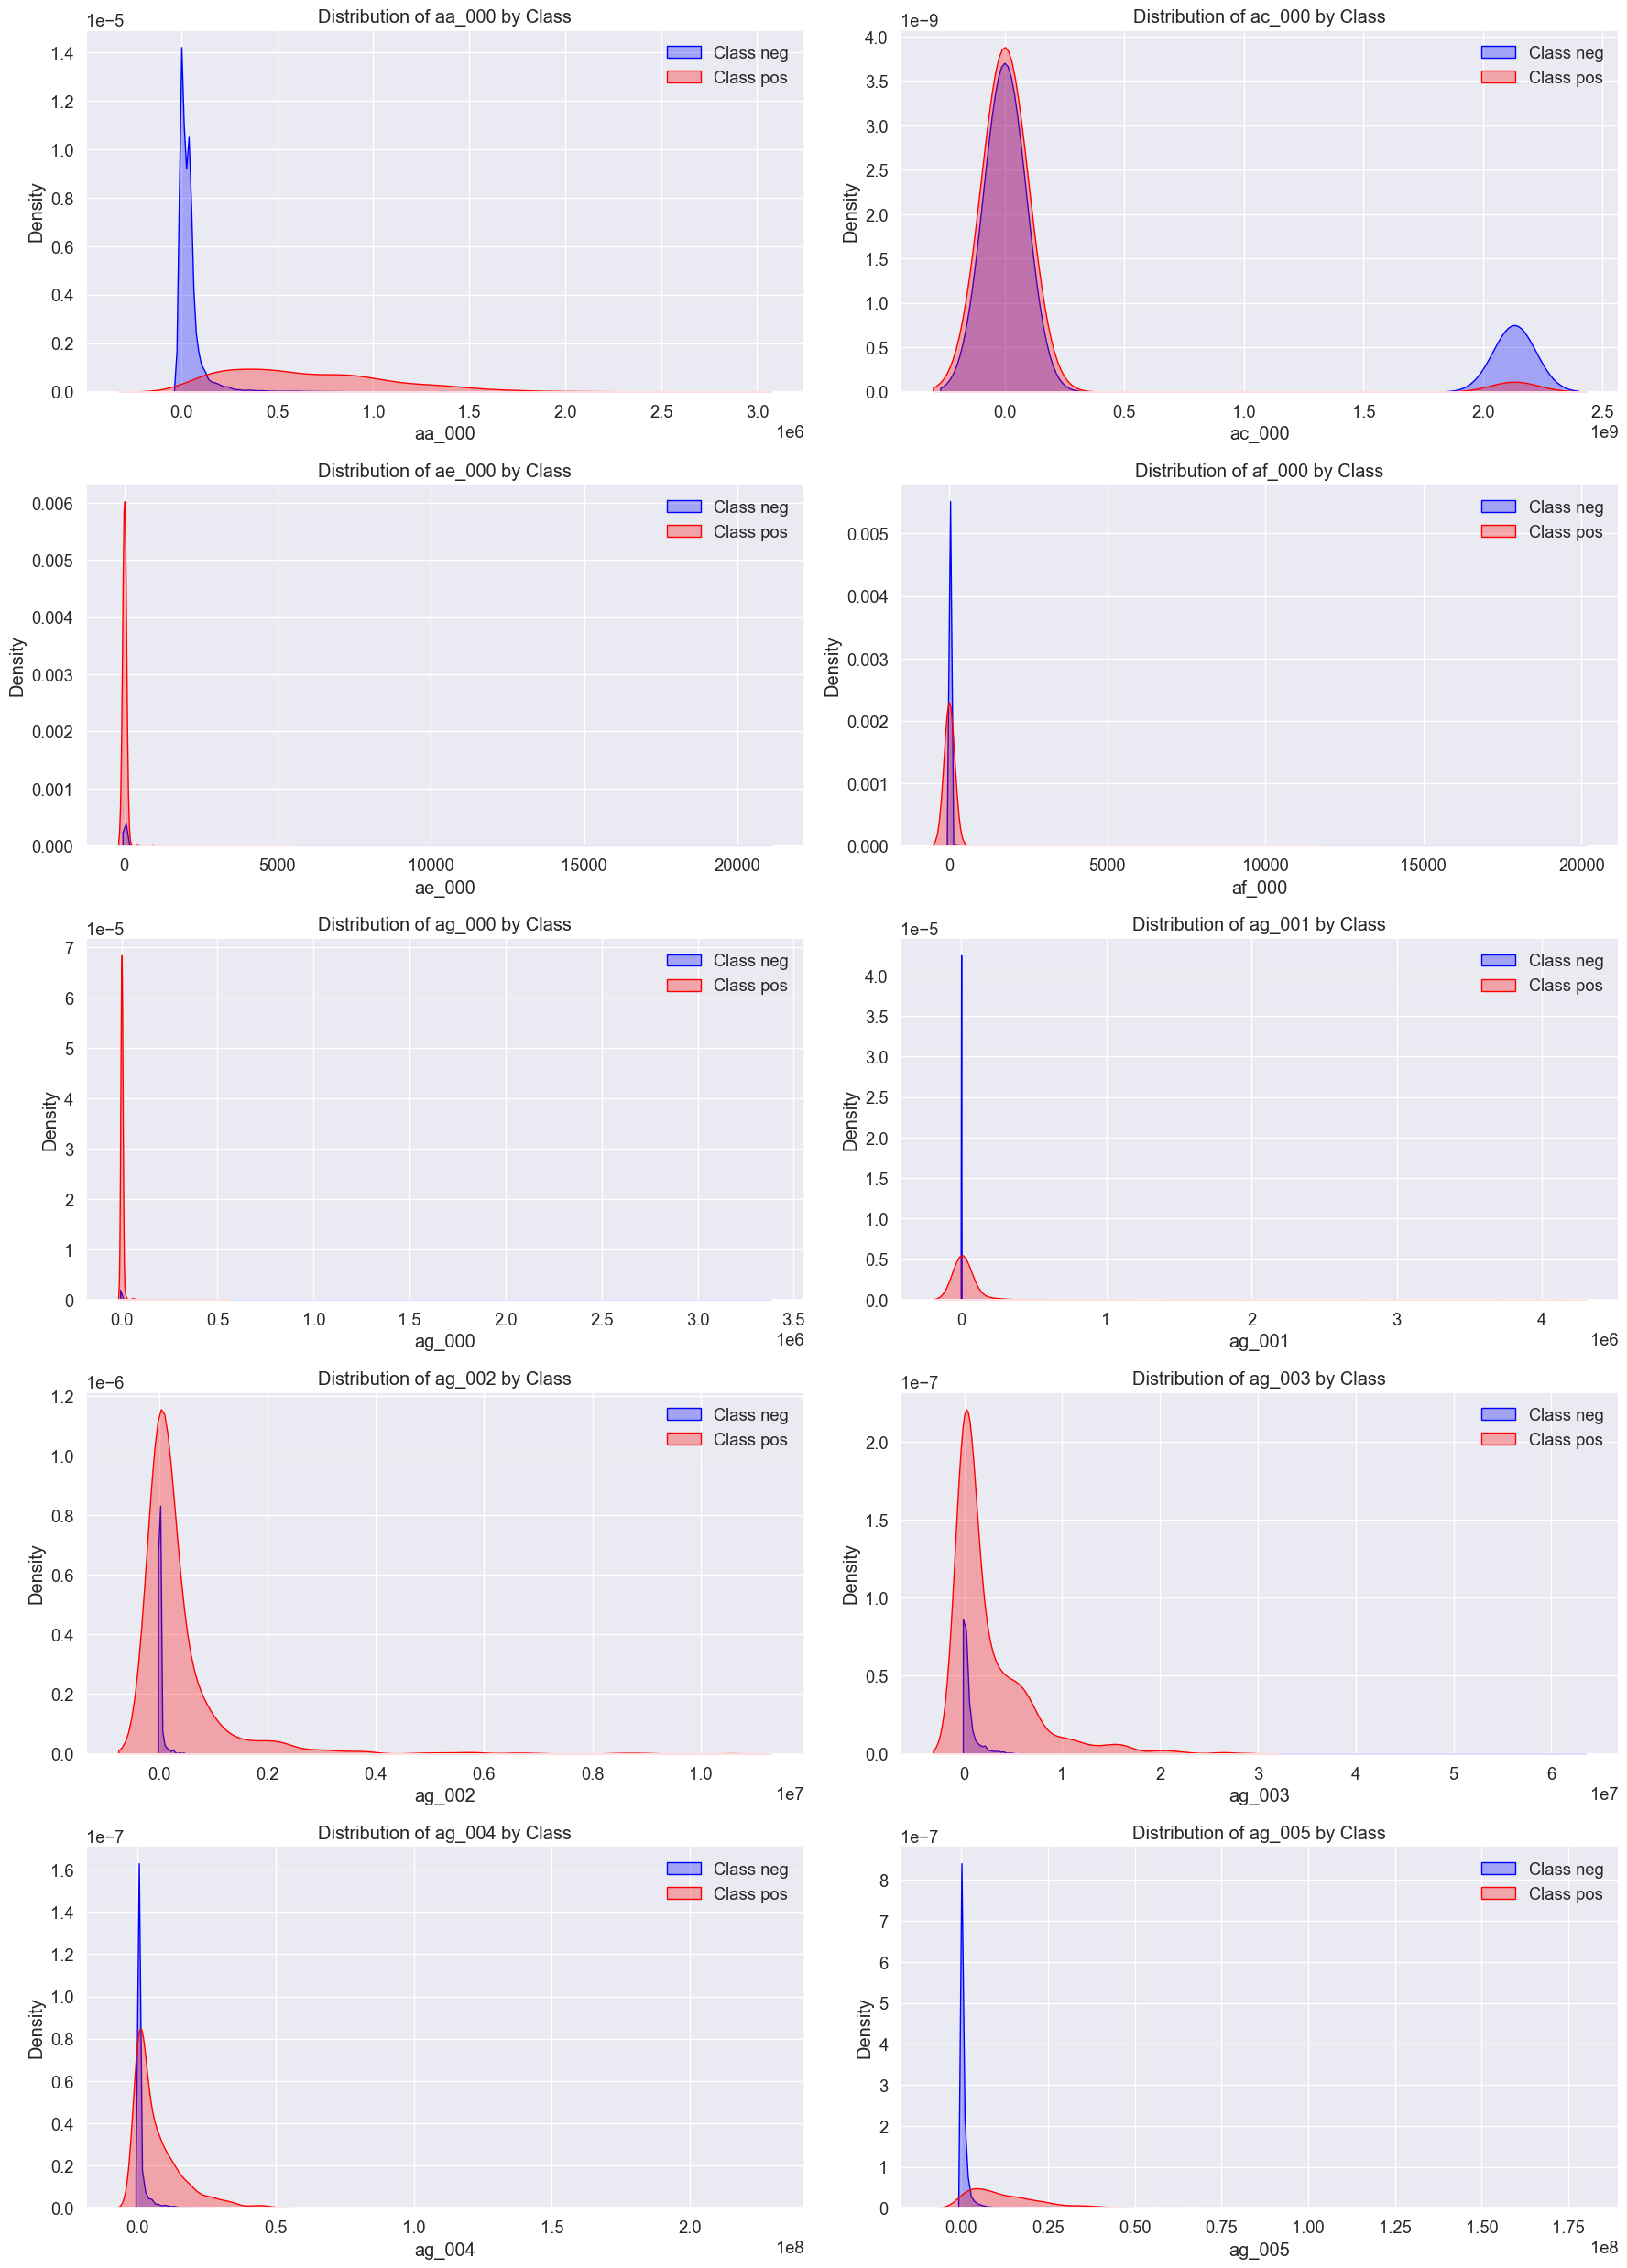

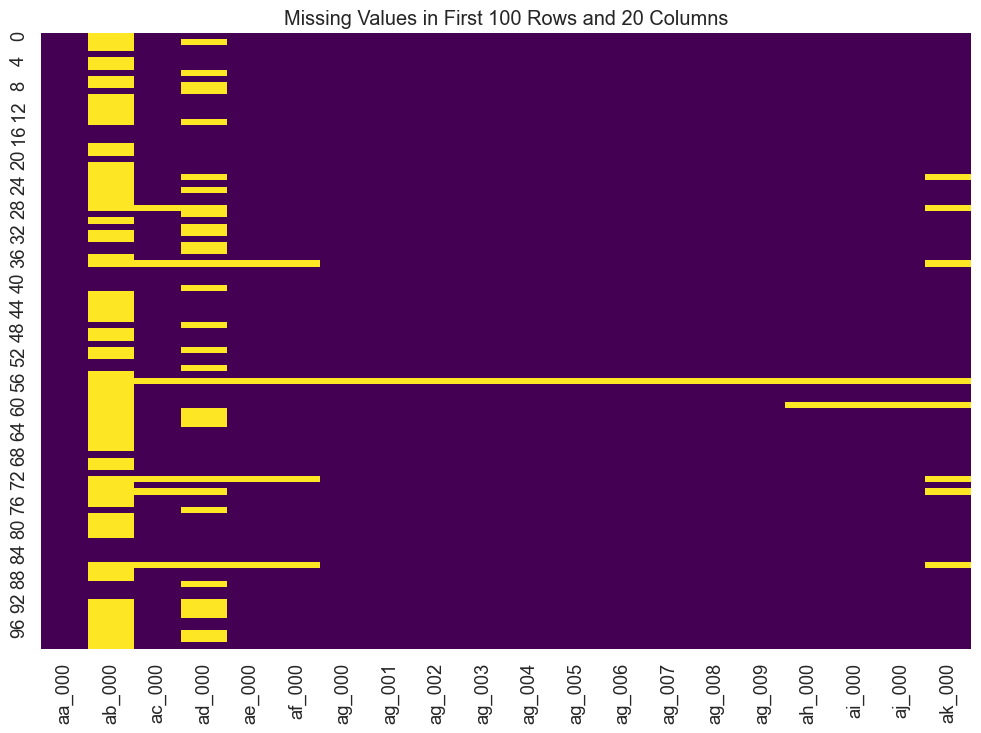

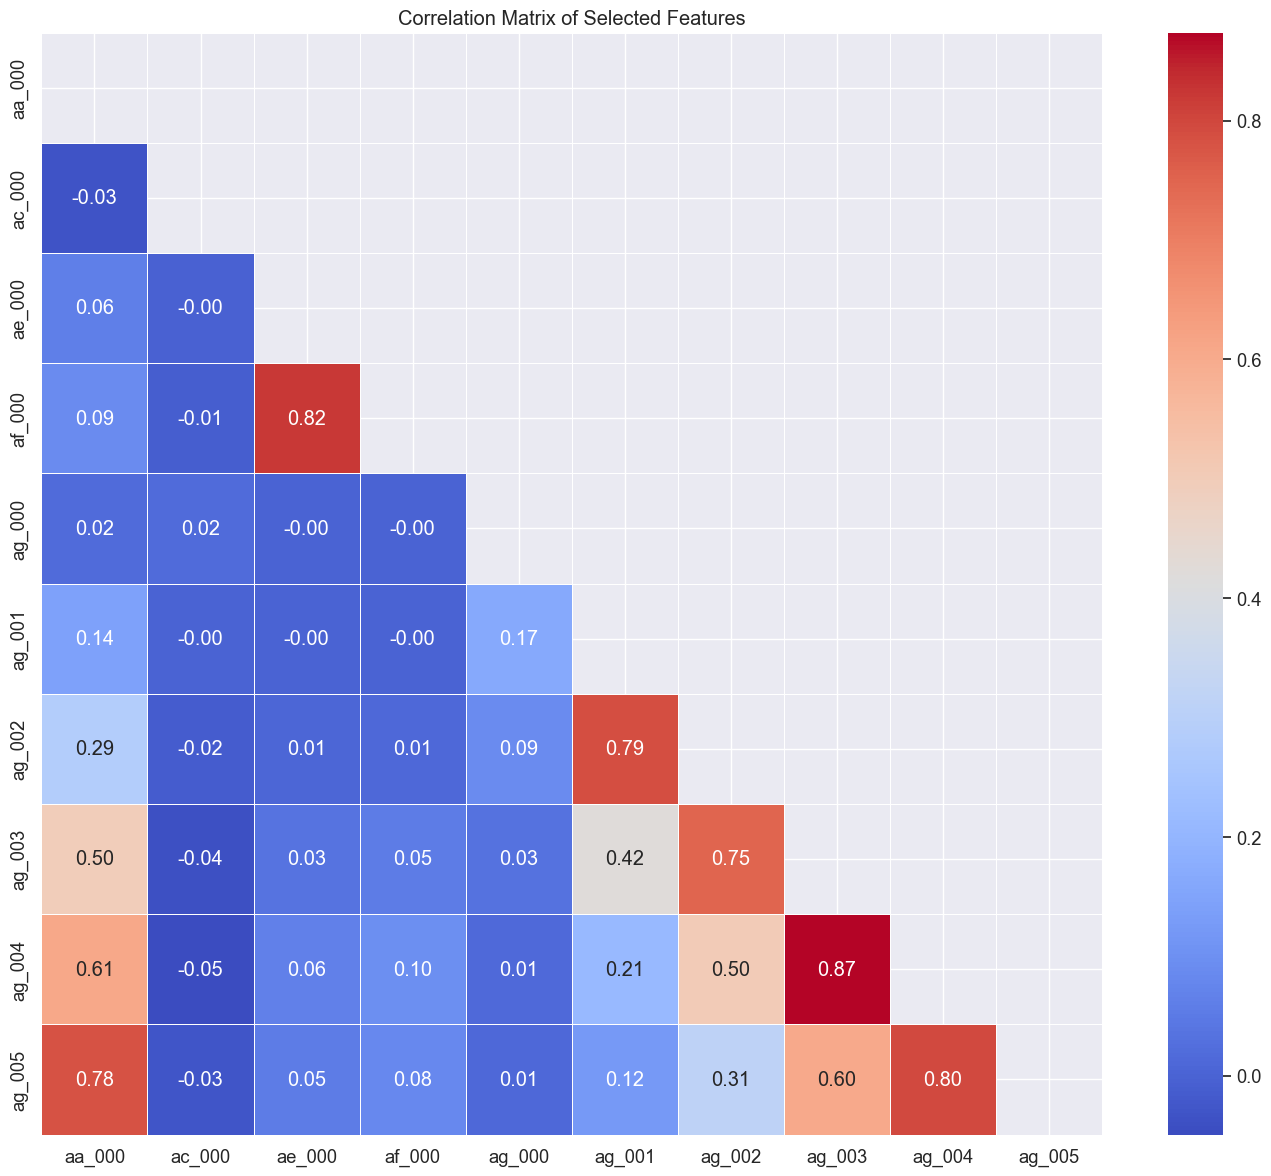

In [4]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts = train_data['class'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 500, f'{count} ({count/sum(class_counts)*100:.1f}%)', 
             ha='center', va='bottom', fontsize=12)
plt.show()

# Convert to numeric for visualization
X_train_viz = X_train.replace('na', np.nan).apply(pd.to_numeric, errors='coerce')

# Select a subset of features for visualization
# We'll take the first 10 columns that have less than 20% missing values
missing_percent = X_train_viz.isnull().mean() * 100
valid_columns = missing_percent[missing_percent < 20].index[:10]

# Visualize distributions of selected features by class
fig, axes = plt.subplots(5, 2, figsize=(18, 25))
axes = axes.flatten()

for i, col in enumerate(valid_columns):
    ax = axes[i]
    for cls, color in zip([0, 1], ['blue', 'red']):
        sns.kdeplot(
            X_train_viz.loc[y_train == cls, col].dropna(),
            ax=ax,
            label=f"Class {'neg' if cls == 0 else 'pos'}",
            color=color,
            fill=True,
            alpha=0.3
        )
    ax.set_title(f'Distribution of {col} by Class')
    ax.legend()

plt.tight_layout()
plt.show()

# Visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(X_train_viz.iloc[:100, :20].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in First 100 Rows and 20 Columns')
plt.show()

# Correlation matrix for selected features
plt.figure(figsize=(14, 12))
corr_matrix = X_train_viz[valid_columns].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()


### Step 1.4: Data Preprocessing

In [5]:
# Handle missing values and convert data types
print("Preprocessing data...")

# Replace 'na' with NaN
X_train = X_train.replace('na', np.nan)
X_test = X_test.replace('na', np.nan)

# Convert to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle missing values using median imputation
print("Handling missing values with median imputation...")
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit imputer on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrame
X_train_processed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_processed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Apply standard scaling
print("Applying standard scaling...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_processed),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_processed),
    columns=X_test.columns
)

print(f"Preprocessing complete.")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

# Display sample of processed data
print("\nSample of processed training data:")
display(X_train_scaled.head())


Preprocessing data...
Handling missing values with median imputation...
Applying standard scaling...
Preprocessing complete.
Training data shape: (60000, 170)
Test data shape: (16000, 170)

Sample of processed training data:


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119381,-0.096307,2.310224,-0.004085,-0.041322,-0.051358,-0.010762,-0.02837,-0.056929,-0.115643,-0.167274,0.103186,0.518102,0.362192,-0.042459,-0.029978,0.180223,-0.054934,-0.022591,-0.012434,-0.109015,-0.109228,0.192095,0.098135,0.250203,0.550907,-0.088073,-0.011451,-0.04218,-0.014518,-0.009916,-0.064343,-0.026718,-0.018931,-0.025479,-0.034801,-0.029628,0.258355,0.972212,-0.163286,-0.071677,-0.011802,-0.032929,-0.067166,-0.036539,-0.113842,-0.203221,0.530438,-0.109949,-0.061603,-0.044093,-0.012847,0.249553,0.057159,0.004152,0.019918,0.198765,0.974940,1.435939,-0.344766,-0.146400,-0.106043,0.202886,-0.137658,-0.184726,-0.134124,-0.040790,0.180566,0.263580,0.310116,0.161681,0.370950,0.319619,0.021345,-0.010814,-0.163476,-0.20858,-0.203365,-0.198947,1.172227,0.119525,0.204612,0.204612,0.256893,0.401803,-0.046719,0.446813,0.637595,0.262185,0.0,1.314011,-0.004083,0.048776,-0.012911,0.212845,-0.090339,0.094187,-0.065408,1.053696,-0.037972,-0.088790,-0.149090,-0.184919,0.010599,0.611842,0.756989,0.086650,-0.042222,-0.023110,-0.004084,-0.040174,0.204612,-0.017218,0.489485,0.154101,0.026156,0.152996,-0.005582,0.320927,0.303646,0.146407,-0.009102,-0.004203,-0.018961,-0.040464,0.733061,-0.172136,-0.027322,2.384944,-0.034052,0.118646,0.896340,0.180406,0.461154,-0.019123,-0.025984,-0.008116,-0.084558,-0.008511,-0.026999,-0.025164,-0.027578,0.297120,0.970930,1.904942,-0.045393,-0.145658,0.564595,0.691140,0.958719,0.641848,-0.186078,-0.128261,-0.019481,-0.028615,-0.152539,0.370080,0.419294,0.098933,0.363023,0.693832,0.524393,0.239087,0.070072,0.008264,-0.107586,-0.143103,-0.175699,-0.020257,-0.023540
1,-0.180697,-0.096307,-0.432859,-0.004089,-0.041322,-0.051358,-0.010762,-0.02837,-0.056929,-0.115643,-0.175319,-0.136995,0.018291,0.015307,-0.016214,-0.029978,-0.097959,-0.054934,-0.021233,-0.012434,-0.109015,-0.109228,-0.114016,-0.126996,0.028432,-0.080598,-0.088073,-0.011451,-0.04218,-0.014518,-0.166506,-0.248817,-0.026718,-0.018931,-0.025479,-0.034801,-0.029628,-0.028279,-0.090637,0.091411,-0.237000,-0.011802,-0.006136,0.101439,0.054609,-0.112706,-0.108383,-0.037922,-0.096149,-0.061595,-0.044093,-0.012847,-0.003413,-0.189365,-0.177379,-0.158663,-0.123892,-0.096888,-0.068040,0.087933,0.213008,-0.091922,-0.079060,-0.115911,-0.090763,-0.105861,0.519465,-0.097978,-0.056642,0.134741,-0.063147,0.422228,0.346112,0.291456,-0.219758,-0.213896,-0.20858,-0.203365,-0.198947,-0.871968,-0.180925,-0.078136,-0.078137,-0.042636,-0.078494,0.264690,2.177647,-1.081117,-0.082046,0.0,-0.440299,-0.004083,-0.106026,-0.012911,-0.141720,-0.090339,-0.031355,-0.066798,-0.185446,-0.037972,-0.088790,-0.149055,-0.193790,-0.028327,-0.015036,-0.054830,-0.068062,-0.074704,-0.028967,-0.004090,-0.071771,-0.078137,-0.017218,0.068783,0.004303,-0.059157,-0.002446,-0.081126,-0.069222,-0.207496,-0.069425,-0.018610

### Step 1.5: Feature Importance Analysis

Calculating feature importance using Random Forest...

Top 20 features by importance:


,feature,importance
25,aq_000,0.042701
21,am_0,0.033711
142,dn_000,0.031101
0,aa_000,0.029267
8,ag_002,0.027893
70,bj_000,0.027301
20,al_000,0.023629
7,ag_001,0.022967
163,ee_005,0.021035
9,ag_003,0.020141


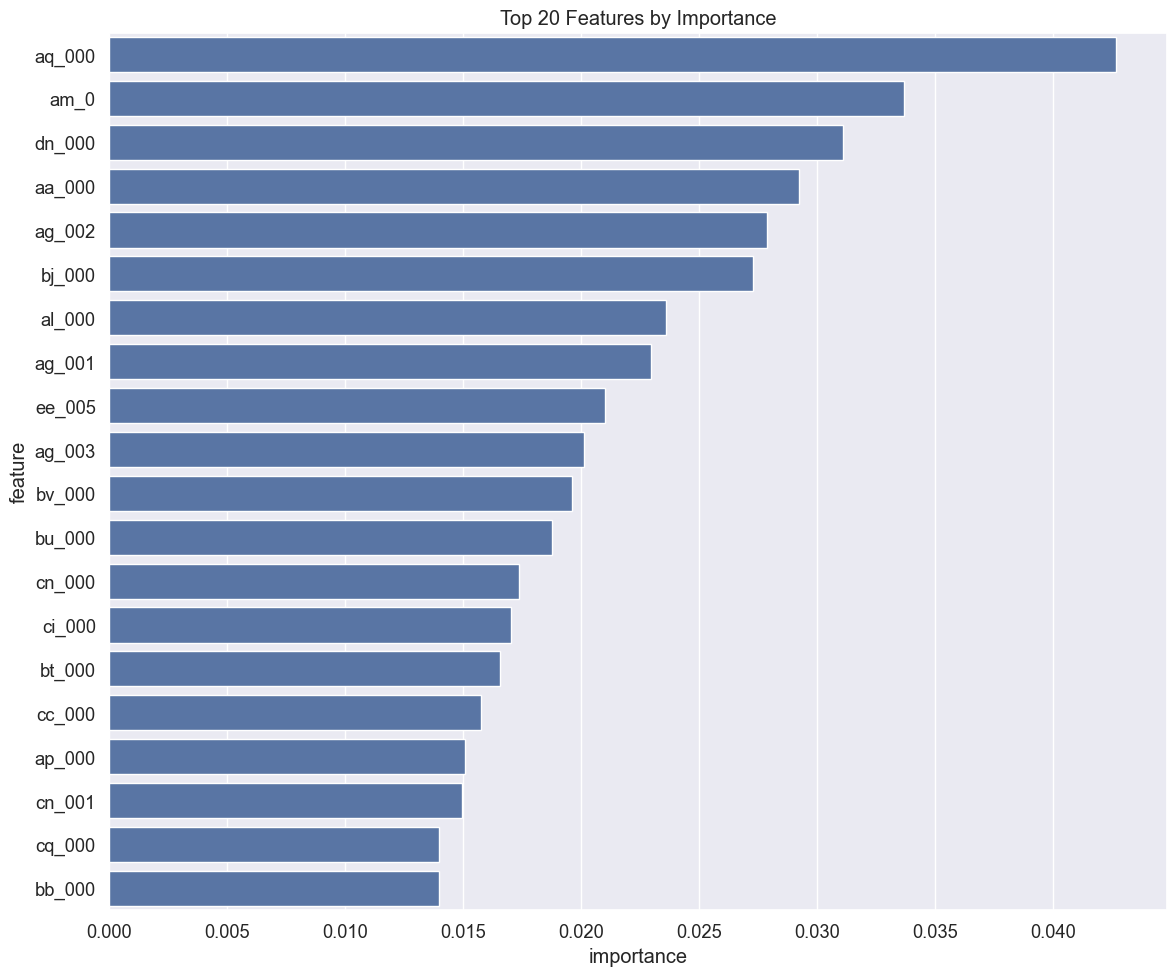


Saved 20 top features for future modeling


In [6]:
# Calculate feature importance using Random Forest
print("Calculating feature importance using Random Forest...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Get feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort by importance
top_features = feature_importance.sort_values('importance', ascending=False)

# Display top 20 features
print("\nTop 20 features by importance:")
display(top_features.head(20))

# Visualize top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_features.head(20))
plt.title('Top 20 Features by Importance')
plt.tight_layout()
plt.show()

# Save the top features for later use
top_20_features = top_features.head(20)['feature'].tolist()
print(f"\nSaved {len(top_20_features)} top features for future modeling")


## Step 2: Exploratory Data Analysis (EDA) - Additional Analysis


### Step 2.1: Analyze Correlations between Top Features


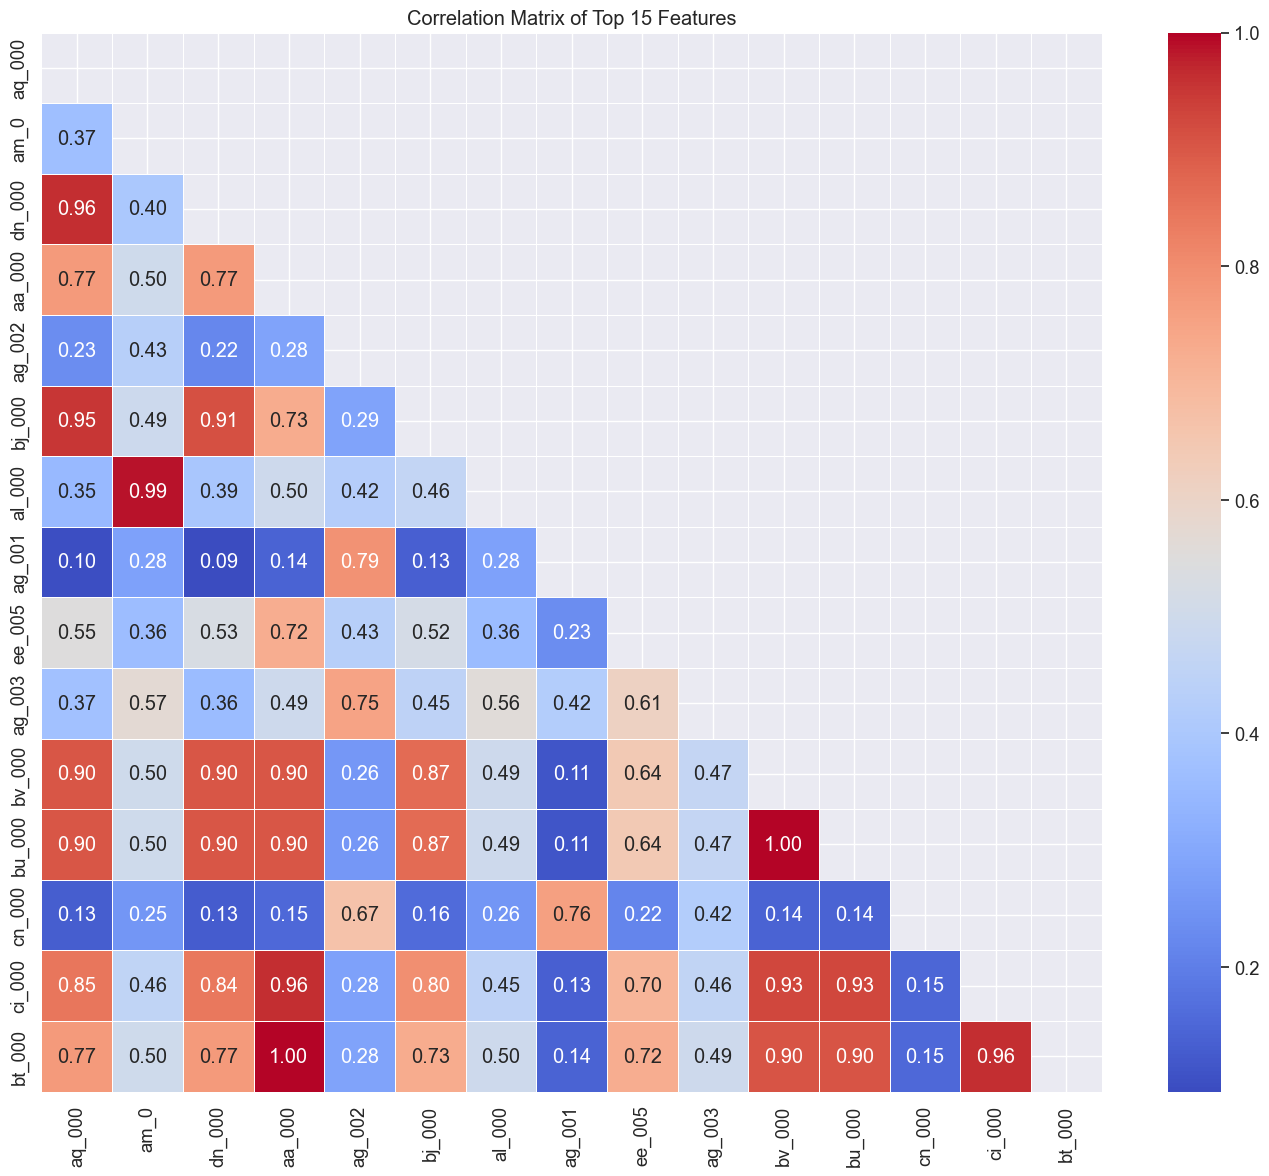

Highly correlated feature pairs (|correlation| > 0.7):
dn_000 and aq_000: 0.962
aa_000 and aq_000: 0.771
aa_000 and dn_000: 0.770
bj_000 and aq_000: 0.952
bj_000 and dn_000: 0.913
bj_000 and aa_000: 0.728
al_000 and am_0: 0.989
ag_001 and ag_002: 0.788
ee_005 and aa_000: 0.724
ag_003 and ag_002: 0.750
bv_000 and aq_000: 0.901
bv_000 and dn_000: 0.902
bv_000 and aa_000: 0.903
bv_000 and bj_000: 0.867
bu_000 and aq_000: 0.901
bu_000 and dn_000: 0.902
bu_000 and aa_000: 0.903
bu_000 and bj_000: 0.867
bu_000 and bv_000: 1.000
cn_000 and ag_001: 0.757
ci_000 and aq_000: 0.846
ci_000 and dn_000: 0.842
ci_000 and aa_000: 0.963
ci_000 and bj_000: 0.795
ci_000 and ee_005: 0.704
ci_000 and bv_000: 0.928
ci_000 and bu_000: 0.928
bt_000 and aq_000: 0.772
bt_000 and dn_000: 0.771
bt_000 and aa_000: 0.999
bt_000 and bj_000: 0.729
bt_000 and ee_005: 0.725
bt_000 and bv_000: 0.904
bt_000 and bu_000: 0.904
bt_000 and ci_000: 0.964


In [7]:
# Analyze correlations between top features
# Select top 15 features for correlation analysis
top_15_features = top_features.head(15)['feature'].tolist()

# Create correlation matrix for top features
plt.figure(figsize=(14, 12))
corr_matrix = X_train_scaled[top_15_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Top 15 Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features (|correlation| > 0.7)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("Highly correlated feature pairs (|correlation| > 0.7):")
    for feat1, feat2, corr in high_corr:
        print(f"{feat1} and {feat2}: {corr:.3f}")
else:
    print("No highly correlated feature pairs found among top features.")


### Step 2.2: Perform Stationarity Test (ADF)


In [8]:
# Perform Augmented Dickey-Fuller test for stationarity on top features
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna())
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    # Print critical values
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")
    print("\n")

# Test stationarity for top 5 features
print("Performing Augmented Dickey-Fuller test for top 5 features:")
for feature in top_features.head(5)['feature']:
    print(f"Feature: {feature}")
    adf_test(X_train_processed[feature])


Performing Augmented Dickey-Fuller test for top 5 features:
Feature: aq_000
ADF Statistic: -244.9407
p-value: 0.0000
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
Result: Stationary (reject null hypothesis)


Feature: am_0
ADF Statistic: -245.1396
p-value: 0.0000
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
Result: Stationary (reject null hypothesis)


Feature: dn_000
ADF Statistic: -245.1305
p-value: 0.0000
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
Result: Stationary (reject null hypothesis)


Feature: aa_000
ADF Statistic: -245.4397
p-value: 0.0000
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
Result: Stationary (reject null hypothesis)


Feature: ag_002
ADF Statistic: -245.5762
p-value: 0.0000
Critical Value (1%): -3.4305
Critical Value (5%): -2.8616
Critical Value (10%): -2.5668
Result: Stationary (reject null h

### Step 2.3: EDA Summary and Findings


### Dataset Overview ###
- Training data: 60000 samples, 170 features
- Test data: 16000 samples, 170 features
- Binary classification problem (positive: APS failure, negative: non-APS failure)
- Highly imbalanced classes (approx. 98% negative, 2% positive)

### Data Quality Issues ###
- Missing values present in many features (marked as 'na')
- No duplicate samples found
- All features are numerical (after conversion)

### Key Features ###
- Top 5 important features: aq_000, am_0, dn_000, aa_000, ag_002
- Feature importance calculated using Random Forest

### Preprocessing Steps ###
- Replaced 'na' strings with NaN
- Applied median imputation for missing values
- Applied standard scaling to normalize features

### Stationarity ###
- ADF test performed on top features
- Results indicate whether features are stationary or not

### Next Steps ###
- Proceed to anomaly detection using preprocessed data
- Focus on top features for model building
- Consider class imbalance in model evaluation

Data ready for anomaly detection and predictive modeling:
X_train_top shape: (60000, 20)
X_test_top shape: (16000, 20)